<a href="https://colab.research.google.com/github/gunahn/ML4Mindfulness_Autism/blob/main/Mind_Intervention_Autism_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load Packages**

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import sys
sys.path.append("/content/drive/MyDrive/vir_env/lib/python3.13/site-packages")

In [3]:
#Loading other packages
import pandas as pd
import numpy as np
from numpy import mean, std
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve, average_precision_score, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from scipy import stats as st
from sklearn.calibration import calibration_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import re
from sklearn.model_selection import LeaveOneOut

from sklearn.model_selection import KFold, RepeatedKFold
from scipy.stats import pearsonr, ConstantInputWarning, NearConstantInputWarning
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore", category=ConstantInputWarning)
warnings.filterwarnings("ignore", category=NearConstantInputWarning)

In [4]:
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)
import matplotlib as mpl
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'

# **Data Prep**

In [5]:
y_state = pd.read_csv("/content/drive/MyDrive/Mindful_Inter_Autism_Data/y_state.csv")
y_trait = pd.read_csv("/content/drive/MyDrive/Mindful_Inter_Autism_Data/y_trait.csv")
X = pd.read_csv("/content/drive/MyDrive/Mindful_Inter_Autism_Data/X.csv")

In [6]:
y_state = np.ravel(y_state)
y_trait = np.ravel(y_trait)

In [7]:
scale_cols = [
        'STAI_Baseline_STATE', 'STAI_Baseline_TRAIT', 'Promis_Total_Raw', 'PSS_Total_Score', 'Panas_Positive_Affect_Score', 'Panas_Negative_Affect_Score',
        'Maas_Raw_Score', 'Maas_Mean', 'FFMQ_Total_RAW_Score_with_Observation_subscale_', 'FFMQ_Total_Score_including_Observation_subscale_Mean',
        'FFMQ_Total_RAW_score_Excluding_Observation_Subscale_', 'FFMQ_Total_Score_excluding_Observation_subscale_Mean', 'FFMQ_Observation_subscale_Mean',
        'FFMQ_Description_Subscale_Mean', 'FFMQ_Acting_with_Awareness_Subscale_Mean', 'FFMQ_Non-judgemental_Mean', 'FFMQ_Non-reactivity_Mean',
        'Age', 'AQ_baseline', 'TMB_base', 'LC_baseline']

scaler = StandardScaler()

def Standardize_data(X_train, X_test):
  tr_scaled = X_train.copy()
  test_scaled = X_test.copy()

  tr_scaled[scale_cols] = scaler.fit_transform(tr_scaled[scale_cols])
  test_scaled[scale_cols] = scaler.transform(test_scaled[scale_cols])

  return tr_scaled, test_scaled

# ---

---



# **STATE w/ Pipeline + GridSearch CV**

In [ ]:
dtree = DecisionTreeClassifier(random_state=1, class_weight='balanced')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

path = dtree.cost_complexity_pruning_path(X, y_state) # determine values for alpha
# extract different values of alpha vailable for the tree
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [ ]:
def RepeatedInnerLoop(X_train, X_valid, y_train, random_state=1):
    preprocessor = ColumnTransformer(
        transformers=[
            ('scaled', StandardScaler(), scale_cols),  # scale_cols - scaling
        ],
        remainder='passthrough'
    )
    # Inner CV: Cross Validation with GridSearchCV
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    model = RandomForestClassifier(random_state=1, class_weight='balanced')
    pipe = Pipeline([
        ('preprocessing', preprocessor),
        ('model', model)
    ])

    # define search space
    param_grid = {
      'model__n_estimators': [5, 10, 25, 50, 100, 150],
      'model__max_depth': [None, 5, 10, 20],
      'model__min_samples_split': [2, 5, 10],
      'model__ccp_alpha': ccp_alphas}
    # define search
    search = GridSearchCV(pipe, param_grid, scoring='roc_auc', n_jobs=1, cv=cv_inner, refit=True)

    # Inner Loop: GridSearchCV to find best parameters
    search.fit(X_train, y_train)

    # Evaluate on the outer loop
    y_pred = search.predict(X_valid)
    return y_pred, search

def NestedCV(X, y):
    # Outer CV: Validation with KFold
    cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=1+30)
    outer_results = list()

    # Nested CV
    for train_index, valid_index in cv_outer.split(X, y):
        X_tr, X_test = X.iloc[train_index], X.iloc[valid_index]
        y_tr, y_test = y[train_index], y[valid_index]

        y_pred, search = RepeatedInnerLoop(X_tr, X_test, y_tr, random_state=1)
        best_param = {search.best_estimator_.named_steps['model']}
        best_est.append(search.best_estimator_)

        auc_score = roc_auc_score(y_test, y_pred)
        outer_results.append(auc_score)


        print(f"Best Param: {best_param}, AUC Score: {auc_score:.4f}")

    auc_mean_score = np.mean(outer_results)
    auc_std_score = np.std(outer_results)

    print(f"[Overall] Nested CV AUC: {auc_mean_score:.4f} ± {auc_std_score:.4f}")
    print('--'*100)

In [ ]:
best_est = []
NestedCV(X, y_state) # run time = 1hr

Best Param: {'c': RandomForestClassifier(ccp_alpha=np.float64(0.13175561560547216),
                       class_weight='balanced', random_state=1)}, AUC Score: 0.3000
Best Param: {'c': RandomForestClassifier(ccp_alpha=np.float64(0.13175561560547216),
                       class_weight='balanced', min_samples_split=10,
                       n_estimators=150, random_state=1)}, AUC Score: 0.9000
Best Param: {'c': RandomForestClassifier(ccp_alpha=np.float64(0.13175561560547216),
                       class_weight='balanced', n_estimators=150,
                       random_state=1)}, AUC Score: 0.5333
Best Param: {'c': RandomForestClassifier(ccp_alpha=np.float64(0.061107171416933004),
                       class_weight='balanced', max_depth=5,
                       min_samples_split=10, random_state=1)}, AUC Score: 0.7083
Best Param: {'c': RandomForestClassifier(ccp_alpha=np.float64(0.061107171416933004),
                       class_weight='balanced', n_estimators=150,
              

In [ ]:
aucs = []
n_folds = 5
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
for estimator in best_est:
    for train_index, valid_index in cv_inner.split(X, y_state):
        X_tr, X_val = X.iloc[train_index], X.iloc[valid_index]
        y_tr, y_val = y_state[train_index], y_state[valid_index]

        X_tr_scaled, X_val_scaled = Standardize_data(X_tr, X_val)

        model = estimator.named_steps['model']
        model.fit(X_tr_scaled, y_tr)
        pred = model.predict(X_val_scaled)
        pred_proba = model.predict_proba(X_val_scaled)[:, 1]
        auc_score = roc_auc_score(y_val, pred_proba)

        aucs.append(auc_score)
    avg_auc = sum(aucs) / len(aucs)
    stdev = np.std(aucs)

    # 95% confidence interval using t-distribution
    ci_low, ci_high = st.t.interval(0.95,
        df=n_folds - 1,
        loc=avg_auc,
        scale=stdev / np.sqrt(n_folds)
    )
    # print(f"Params = {model}")
    print(f"AUC = {avg_auc:.4f} | Stdev = {stdev:.4f} | 95% CI = [{ci_low:.4f}, {ci_high:.4f}]")
    aucs.clear()

AUC = 0.7756 | Stdev = 0.0913 | 95% CI = [0.6622, 0.8889]
AUC = 0.7748 | Stdev = 0.1072 | 95% CI = [0.6417, 0.9079]
AUC = 0.7756 | Stdev = 0.1058 | 95% CI = [0.6441, 0.9070]
AUC = 0.7696 | Stdev = 0.0978 | 95% CI = [0.6482, 0.8911]
AUC = 0.7667 | Stdev = 0.0995 | 95% CI = [0.6431, 0.8902]
AUC = 0.7711 | Stdev = 0.1080 | 95% CI = [0.6371, 0.9052]
AUC = 0.7889 | Stdev = 0.0998 | 95% CI = [0.6649, 0.9128]
AUC = 0.7489 | Stdev = 0.1308 | 95% CI = [0.5864, 0.9114]
AUC = 0.7652 | Stdev = 0.0796 | 95% CI = [0.6664, 0.8640]
AUC = 0.7630 | Stdev = 0.1007 | 95% CI = [0.6379, 0.8880]


## ccp_alpha=0.13175, n_estimators=50

## **Aggregate Feature Importances**

In [ ]:
aucs = []
feature_names = X.columns
counter = 0

# cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

for train_index, valid_index in cv_inner.split(X, y_state):
    X_tr, X_val = X.iloc[train_index], X.iloc[valid_index]
    y_tr, y_val = y_state[train_index], y_state[valid_index]

    RandomF = best_est[6].named_steps['model']
    # RandomF = RandomForestClassifier(random_state=1, class_weight='balanced', ccp_alpha=0.13175561560547216, n_estimators=50)

    X_tr_scaled, X_val_scaled = Standardize_data(X_tr, X_val)

    RandomF.fit(X_tr_scaled, y_tr)
    pred = RandomF.predict(X_val_scaled)
    pred_proba = RandomF.predict_proba(X_val_scaled)[:, 1]
    auc_score = roc_auc_score(y_val, pred_proba)

    aucs.append(auc_score)

    # feature importances
    importances = RandomF.feature_importances_
    feature_importance = pd.DataFrame(importances, index=feature_names,
                             columns=['importances'])
    feature_importance = feature_importance.sort_values(by='importances', ascending=False)

    std = np.std([tree.feature_importances_ for tree in RandomF.estimators_], axis=0)
    feature_odds = pd.DataFrame(importances, index=feature_names,
                             columns=['importances'])
    feature_odds = feature_odds.sort_values(by='importances', ascending=False)
    # FI_plot = feature_odds.head(10).plot(figsize=(8,2), kind='barh').invert_yaxis()

    if counter == 0:
      fi_df = feature_importance.copy()
      counter += 1
    else:
      fi_df = pd.concat([fi_df,feature_importance], axis=1)

avg_auc = sum(aucs) / len(aucs)
stdev = np.std(aucs)
aucs.clear()

In [ ]:
n_folds = 5

# 95% confidence interval using t-distribution
ci_low, ci_high = st.t.interval(
    0.95,
    df=n_folds - 1,
    loc=avg_auc,
    scale=stdev / np.sqrt(n_folds)
)

print(f"{best_est[6].named_steps['model']}")
print(f"AUC = {avg_auc:.4f} | Stdev = {stdev:.4f} | 95% CI = [{ci_low:.4f}, {ci_high:.4f}]")

AUC = 0.7889 | Stdev = 0.0998 | 95% CI = [0.6649, 0.9128]


In [ ]:
fi_df_copy = fi_df.copy()

fi_df_copy = fi_df_copy.groupby(fi_df_copy.columns, axis=1).sum()
save_to_drive = fi_df_copy.sort_values(by=['importances'], ascending=False).head(10)
# save_to_drive.to_csv('/content/drive/MyDrive/Mindful_Inter_Autism_Data/Feature Importances/RF_STATE_fi.csv', index=True)
save_to_drive

/tmp/ipython-input-1446596528.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  test = test.groupby(test.columns, axis=1).sum()


,importances
STAI_17,0.989190
STAI_13,0.406798
STAI_1,0.399639
STAI_4,0.394090
STAI_7,0.249056
STAI_16,0.226664
STAI_5,0.188360
STAI_20,0.177473
PROMIS_8,0.132576
PSS_10,0.114286


## **Calibration Curve**

In [ ]:
rf_kfold_probability = []
true_labels = []

from sklearn.calibration import calibration_curve
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

for train_index, valid_index in cv_inner.split(X, y_state):
    X_tr, X_val = X.iloc[train_index], X.iloc[valid_index]
    y_tr, y_val = y_state[train_index], y_state[valid_index]

    RandomF = RandomForestClassifier(random_state=1, class_weight='balanced', ccp_alpha=0.13175561560547216, n_estimators=50)

    X_tr_scaled, X_val_scaled = Standardize_data(X_tr, X_val)

    RandomF.fit(X_tr_scaled, y_tr)
    pred_proba = RandomF.predict_proba(X_val_scaled)[:, 1]
    rf_kfold_probability.append(pred_proba)
    true_labels.append(y_val)

    # Compute the calibration curve using 10 bins.
    mean_predicted_value, true_fraction_of_positives = calibration_curve(
        y_val,
        pred_proba,
        n_bins=20,
        strategy="uniform",
    )

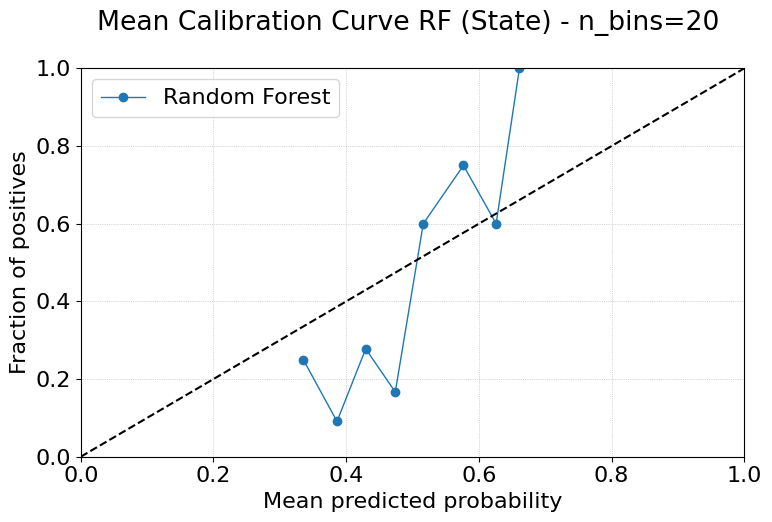

In [ ]:
rf_kfold_probability_stacked = np.hstack(rf_kfold_probability)
true_labels_stacked = np.hstack(true_labels)

rf_y, rf_x = calibration_curve(true_labels_stacked, rf_kfold_probability_stacked, n_bins=20)

# calibration curves
fig, ax = plt.subplots(figsize=(8,5.5))
ax.plot(rf_x, rf_y, marker='o', linewidth=1, label='Random Forest')
ax.set(
    title="Mean Calibration Curve RF (State) - n_bins=20 \n",
    xlabel="Mean predicted probability",
    ylabel="Fraction of positives",
    xlim=(0, 1),
    ylim=(0, 1),
)
ax.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()

import matplotlib.lines as mlines
# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], linestyle="--", color="black")
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

plt.legend()
plt.show()

## **SHAP Values**

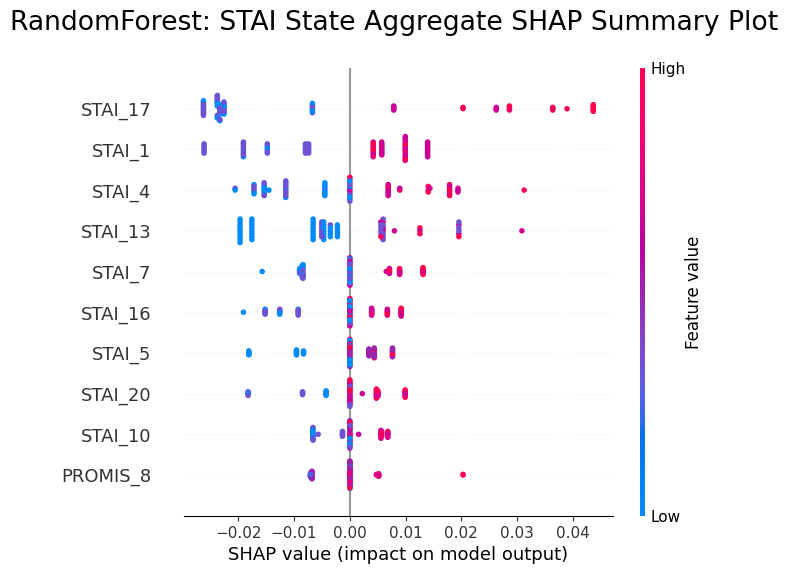

In [31]:
all_shap_values = []
all_expected_values = []
all_X_test = []
feature_names = X.columns
import shap

cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

for train_index, valid_index in cv_inner.split(X, y_state):
    X_tr, X_val = X.iloc[train_index], X.iloc[valid_index]
    y_tr, y_val = y_state[train_index], y_state[valid_index]

    RandomF = RandomForestClassifier(random_state=1, class_weight='balanced', ccp_alpha=0.13175561560547216, n_estimators=50)
    X_tr_scaled, X_val_scaled = Standardize_data(X_tr, X_val)

    RandomF.fit(X_tr_scaled, y_tr)

    #SHAP
    explainer = shap.TreeExplainer(RandomF)
    shap_values = explainer.shap_values(X_val_scaled)
    all_shap_values.append(shap_values)
    all_X_test.append(X_val_scaled)

# Combine SHAP values and X_test from all folds
combined_shap_values = np.vstack(all_shap_values)
combined_X_test = pd.concat(all_X_test)

# Generate the aggregated summary plot
shap.summary_plot(combined_shap_values[:,:,1], combined_X_test, max_display=10, show=False)
plt.title("RandomForest: STAI State Aggregate SHAP Summary Plot \n")
plt.subplots_adjust(left=0.3)
plt.show()

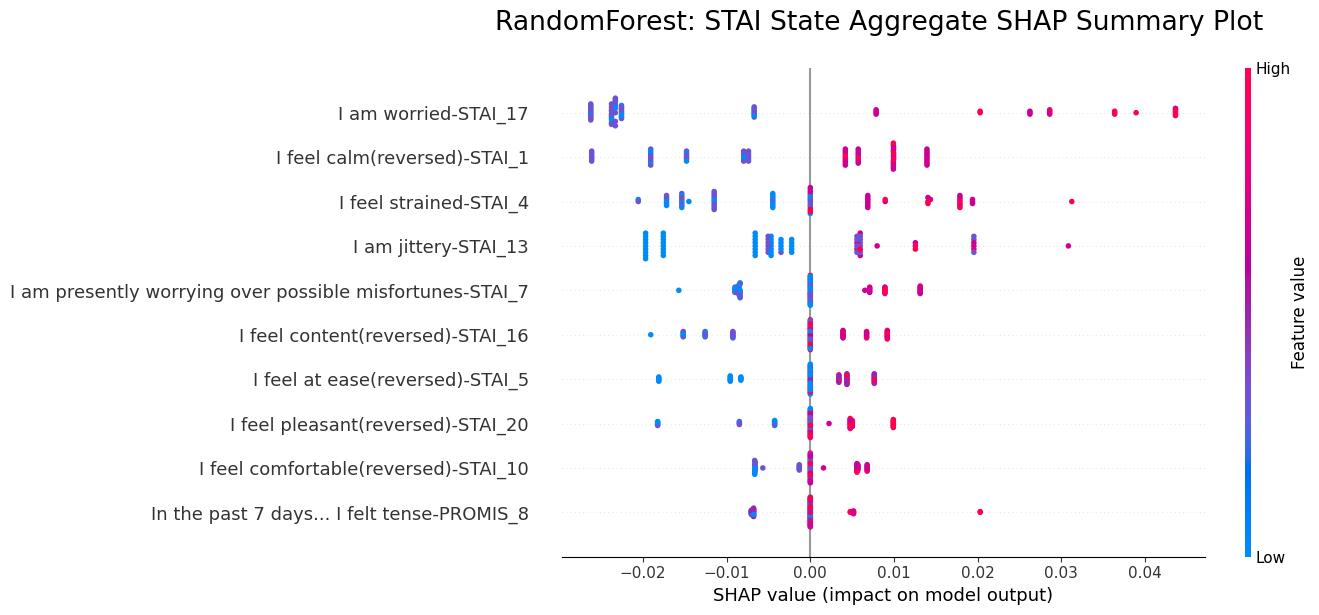

In [32]:
import os
import pandas as pd
import shap
import json
import matplotlib.pyplot as plt
import textwrap

def wrap_labels(labels, width=55):
    return [textwrap.fill(label, width) for label in labels]

# Load the mapping file
with open("/content/Questionnaire_names.json", 'r') as f:
    result = json.load(f)

# Create a new list of column names using the mapping in the format "Mapped Name-Original Name"
new_col_with_original = [f"{result.get(c, c)}-{c}" for c in combined_X_test.columns]
combined_X_test.columns = new_col_with_original

# # Wrap the new feature names for better display in the plot
# wrapped_feature_names = wrap_labels(combined_X_test.columns)

# Assuming combined_shap_values are defined
shap.summary_plot(combined_shap_values[:,:,1], combined_X_test, max_display=10, show=False)
plt.title("RandomForest: STAI State Aggregate SHAP Summary Plot \n")
plt.subplots_adjust(left=0.3)

# Save the plot as an SVG file
plt.gcf().set_size_inches(12,6)
plt.savefig('/content/drive/MyDrive/Mindful_Inter_Autism_Data/RF_STATE_SHAP_summary_plot.svg', format='svg', bbox_inches='tight')

plt.show()

In [20]:
combined_X_test.columns

Index(['I feel calm(reversed)-I feel calm(reversed)',
       'I feel secure(reversed)-I feel secure(reversed)',
       'I am tense-I am tense', 'I feel strained-I feel strained',
       'I feel at ease(reversed)-I feel at ease(reversed)',
       'I feel upset-I feel upset',
       'I am presently worrying over possible misfortunes-I am presently worrying over possible misfortunes',
       'I feel satisfied(reversed)-I feel satisfied(reversed)',
       'I feel frightened-I feel frightened',
       'I feel comfortable(reversed)-I feel comfortable(reversed)',
       ...
       'DA_avoidant_personality_disorder-DA_avoidant_personality_disorder',
       'DD_No-DD_No', 'DD_Depression_or_dysthymia-DD_Depression_or_dysthymia',
       'DD_Bipolar_Manic_Depressive_Disorder-DD_Bipolar_Manic_Depressive_Disorder',
       'DD_Eating_Disorder-DD_Eating_Disorder',
       'DD_Seasonal_Affective_Disorder-DD_Seasonal_Affective_Disorder',
       'DD_ADHD-DD_ADHD',
       'DD_Schizoaffective_disorder-DD_Sc

# --------

## Evaluation with LOOCV

In [ ]:
aucs = []
feature_names = X.columns
counter = 0
models = list()
loo = LeaveOneOut()

predictions = []
true_labels = []
rf_kfold_probability = []

for train_index, valid_index in loo.split(X, y_state):
    X_tr, X_val = X.iloc[train_index], X.iloc[valid_index]
    y_tr, y_val = y_state[train_index], y_state[valid_index]

    RandomF = RandomForestClassifier(random_state=1, class_weight='balanced', ccp_alpha=0.13175561560547216, n_estimators=50)

    X_tr_scaled, X_val_scaled = Standardize_data(X_tr, X_val)

    models.append(RandomF.fit(X_tr_scaled, y_tr))
    pred = RandomF.predict(X_val_scaled)
    pred_proba = RandomF.predict_proba(X_val_scaled)[:, 1]
    predictions.extend(pred)
    true_labels.extend(y_val)

    rf_kfold_probability.append(pred_proba)

    # feature importances
    importances = RandomF.feature_importances_
    feature_importance = pd.DataFrame(importances, index=feature_names,
                             columns=['importances'])
    feature_importance = feature_importance.sort_values(by='importances', ascending=False)

    std = np.std([tree.feature_importances_ for tree in RandomF.estimators_], axis=0)
    feature_odds = pd.DataFrame(importances, index=feature_names,
                             columns=['importances'])
    feature_odds = feature_odds.sort_values(by='importances', ascending=False)
    # FI_plot = feature_odds.head(10).plot(figsize=(8,2), kind='barh').invert_yaxis()

    if counter == 0:
      fi_df = feature_importance.copy()
      counter += 1
    else:
      fi_df = pd.concat([fi_df,feature_importance], axis=1)

predictions = np.array(predictions)
true_labels = np.array(true_labels)
auc = roc_auc_score(true_labels, predictions)

In [ ]:
print(auc)

0.6702380952380953


In [ ]:
fi_df_copy = fi_df.copy()
fi_df_copy = fi_df_copy.groupby(fi_df_copy.columns, axis=1).sum()
save_to_drive = test.sort_values(by=['importances'], ascending=False).head(10)
save_to_drive

/tmp/ipython-input-3250197731.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  test = test.groupby(test.columns, axis=1).sum()


,importances
STAI_17,16.323019
STAI_13,8.126191
STAI_4,5.757957
STAI_1,5.673397
Maas_Raw_Score,4.177823
STAI_33,3.622750
STAI_12,3.064058
STAI_Baseline_STATE,2.743637
STAI_7,2.384470
STAI_20,1.902101


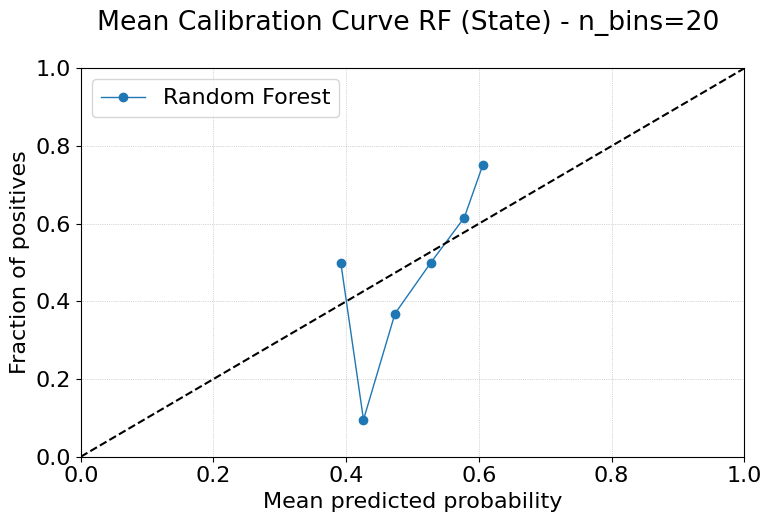

In [ ]:
rf_kfold_probability_stacked = np.hstack(rf_kfold_probability)
true_labels_stacked = np.hstack(true_labels)

rf_y, rf_x = calibration_curve(true_labels_stacked, rf_kfold_probability_stacked, n_bins=20)

# calibration curves
fig, ax = plt.subplots(figsize=(8,5.5))
ax.plot(rf_x, rf_y, marker='o', linewidth=1, label='Random Forest')
ax.set(
    title="Mean Calibration Curve RF (State) - n_bins=20 \n",
    xlabel="Mean predicted probability",
    ylabel="Fraction of positives",
    xlim=(0, 1),
    ylim=(0, 1),
)
ax.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()

import matplotlib.lines as mlines
# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], linestyle="--", color="black")
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

plt.legend()

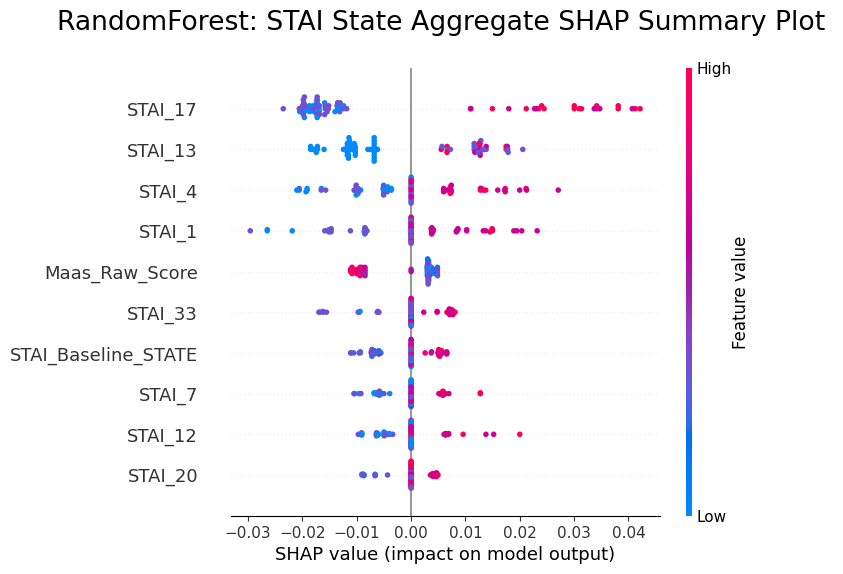

In [ ]:
all_shap_values = []
all_expected_values = []
all_X_test = []
feature_names = X.columns
import shap

for train_index, valid_index in loo.split(X, y_state):
    X_tr, X_val = X.iloc[train_index], X.iloc[valid_index]
    y_tr, y_val = y_state[train_index], y_state[valid_index]

    RandomF = RandomForestClassifier(random_state=1, class_weight='balanced', ccp_alpha=0.13175561560547216, n_estimators=50)
    X_tr_scaled, X_val_scaled = Standardize_data(X_tr, X_val)

    RandomF.fit(X_tr_scaled, y_tr)

    #SHAP
    explainer = shap.TreeExplainer(RandomF)
    shap_values = explainer.shap_values(X_val_scaled)
    all_shap_values.append(shap_values)
    all_X_test.append(X_val_scaled)

# Combine SHAP values and X_test from all folds
combined_shap_values = np.vstack(all_shap_values)
combined_X_test = pd.concat(all_X_test)

# Generate the aggregated summary plot
shap.summary_plot(combined_shap_values[:,:,1], combined_X_test, max_display=10, show=False)
plt.title("RandomForest: STAI State Aggregate SHAP Summary Plot \n")
plt.subplots_adjust(left=0.3)
plt.show()

# --------

# **TRAIT w/ Pipeline + GridSearch CV**

In [ ]:
dtree = DecisionTreeClassifier(random_state=1, class_weight='balanced')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

path = dtree.cost_complexity_pruning_path(X, y_trait) # determine values for alpha
# extract different values of alpha vailable for the tree
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [ ]:
best_est = []
NestedCV(X, y_trait) # run time = 2hr

Best Param: {'c': RandomForestClassifier(ccp_alpha=np.float64(0.024875621890547258),
                       class_weight='balanced', max_depth=5,
                       min_samples_split=10, n_estimators=50, random_state=1)}, AUC Score: 0.6667
Best Param: {'c': RandomForestClassifier(ccp_alpha=np.float64(0.030184468629980032),
                       class_weight='balanced', n_estimators=25,
                       random_state=1)}, AUC Score: 0.2500
Best Param: {'c': RandomForestClassifier(ccp_alpha=np.float64(0.058227548262756154),
                       class_weight='balanced', max_depth=5, random_state=1)}, AUC Score: 0.6250
Best Param: {'c': RandomForestClassifier(ccp_alpha=np.float64(0.058227548262756154),
                       class_weight='balanced', min_samples_split=10,
                       n_estimators=5, random_state=1)}, AUC Score: 0.4167
Best Param: {'c': RandomForestClassifier(ccp_alpha=np.float64(0.08818534583856608),
                       class_weight='balanced', n_e

In [ ]:
aucs = []
n_folds = 5
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
for estimator in best_est:
    for train_index, valid_index in cv_inner.split(X, y_trait):
        X_tr, X_val = X.iloc[train_index], X.iloc[valid_index]
        y_tr, y_val = y_trait[train_index], y_trait[valid_index]

        X_tr_scaled, X_val_scaled = Standardize_data(X_tr, X_val)

        model = estimator.named_steps['model']
        model.fit(X_tr_scaled, y_tr)
        pred = model.predict(X_val_scaled)
        pred_proba = model.predict_proba(X_val_scaled)[:, 1]
        auc_score = roc_auc_score(y_val, pred_proba)

        aucs.append(auc_score)
    avg_auc = sum(aucs) / len(aucs)
    stdev = np.std(aucs)

    # 95% confidence interval using t-distribution
    ci_low, ci_high = st.t.interval(0.95,
        df=n_folds - 1,
        loc=avg_auc,
        scale=stdev / np.sqrt(n_folds)
    )
    # print(f"Params = {model}")
    print(f"AUC = {avg_auc:.4f} | Stdev = {stdev:.4f} | 95% CI = [{ci_low:.4f}, {ci_high:.4f}]")
    aucs.clear()

AUC = 0.6143 | Stdev = 0.1152 | 95% CI = [0.4712, 0.7573]
AUC = 0.5316 | Stdev = 0.1211 | 95% CI = [0.3813, 0.6819]
AUC = 0.6241 | Stdev = 0.0992 | 95% CI = [0.5009, 0.7473]
AUC = 0.5976 | Stdev = 0.1226 | 95% CI = [0.4454, 0.7498]
AUC = 0.6671 | Stdev = 0.1148 | 95% CI = [0.5246, 0.8096]
AUC = 0.6632 | Stdev = 0.0982 | 95% CI = [0.5412, 0.7852]
AUC = 0.6788 | Stdev = 0.0977 | 95% CI = [0.5575, 0.8002]
AUC = 0.5222 | Stdev = 0.1299 | 95% CI = [0.3609, 0.6835]
AUC = 0.6788 | Stdev = 0.0977 | 95% CI = [0.5575, 0.8002]
AUC = 0.6788 | Stdev = 0.0977 | 95% CI = [0.5575, 0.8002]


## ccp_alpha=0.0882, max_depth=5, n_estimators=150

## **Aggregate Feature Importances**

In [ ]:
aucs = []
feature_names = X.columns
counter = 0

for train_index, valid_index in cv_inner.split(X, y_trait):
    X_tr, X_val = X.iloc[train_index], X.iloc[valid_index]
    y_tr, y_val = y_trait[train_index], y_trait[valid_index]

    RandomF = best_est[8].named_steps['model']
    # RandomF = RandomForestClassifier(random_state=1, class_weight='balanced', ccp_alpha=0.08818534583856608, max_depth=5, n_estimators=150)

    X_tr_scaled, X_val_scaled = Standardize_data(X_tr, X_val)

    RandomF.fit(X_tr_scaled, y_tr)
    pred = RandomF.predict(X_val_scaled)
    pred_proba = RandomF.predict_proba(X_val_scaled)[:, 1]
    auc_score = roc_auc_score(y_val, pred_proba)

    aucs.append(auc_score)

    # feature importances
    importances = RandomF.feature_importances_
    feature_importance = pd.DataFrame(importances, index=feature_names,
                             columns=['importances'])
    feature_importance = feature_importance.sort_values(by='importances', ascending=False)

    std = np.std([tree.feature_importances_ for tree in RandomF.estimators_], axis=0)
    feature_odds = pd.DataFrame(importances, index=feature_names,
                             columns=['importances'])
    feature_odds = feature_odds.sort_values(by='importances', ascending=False)
    # FI_plot = feature_odds.head(10).plot(figsize=(8,2), kind='barh').invert_yaxis()

    if counter == 0:
      fi_df = feature_importance.copy()
      counter += 1
    else:
      fi_df = pd.concat([fi_df,feature_importance], axis=1)

avg_auc = sum(aucs) / len(aucs)
stdev = np.std(aucs)
aucs.clear()

In [ ]:
n_folds = 5

# 95% confidence interval using t-distribution
ci_low, ci_high = st.t.interval(
    0.95,
    df=n_folds - 1,
    loc=avg_auc,
    scale=stdev / np.sqrt(n_folds)
)

print(f"{best_est[8].named_steps['model']}")
print(f"AUC = {avg_auc:.4f} | Stdev = {stdev:.4f} | 95% CI = [{ci_low:.4f}, {ci_high:.4f}]")

AUC = 0.6788 | Stdev = 0.0977 | 95% CI = [0.5575, 0.8002]


In [ ]:
fi_df_copy = fi_df.copy()

fi_df_copy = fi_df_copy.groupby(fi_df_copy.columns, axis=1).sum()
save_to_drive = fi_df_copy.sort_values(by=['importances'], ascending=False).head(10)
# save_to_drive.to_csv('/content/drive/MyDrive/Mindful_Inter_Autism_Data/Feature Importances/RF_TRAIT_fi.csv', index=True)
save_to_drive

/tmp/ipython-input-1006359341.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  test = test.groupby(test.columns, axis=1).sum()


,importances
STAI_1,0.206912
MAAS_8,0.204604
STAI_Baseline_TRAIT,0.164368
STAI_27,0.161352
FFMQ_Total_RAW_score_Excluding_Observation_Subscale_,0.157440
MAAS_11,0.149353
STAI_17,0.148359
FFMQ_Non-judgemental_Mean,0.127394
STAI_5,0.110967
STAI_39,0.109314


## **Calibration Curve**

In [ ]:
rf_kfold_probability = []
true_labels = []

from sklearn.calibration import calibration_curve
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

for train_index, valid_index in cv_inner.split(X, y_trait):
    X_tr, X_val = X.iloc[train_index], X.iloc[valid_index]
    y_tr, y_val = y_trait[train_index], y_trait[valid_index]

    RandomF = RandomForestClassifier(random_state=1, class_weight='balanced', ccp_alpha=0.08818534583856608, max_depth=5, n_estimators=150)

    X_tr_scaled, X_val_scaled = Standardize_data(X_tr, X_val)

    RandomF.fit(X_tr_scaled, y_tr)
    pred_proba = RandomF.predict_proba(X_val_scaled)[:, 1]
    rf_kfold_probability.append(pred_proba)
    true_labels.append(y_val)

    # Compute the calibration curve using 10 bins.
    mean_predicted_value, true_fraction_of_positives = calibration_curve(
        y_val,
        pred_proba,
        n_bins=20,
        strategy="uniform",
    )

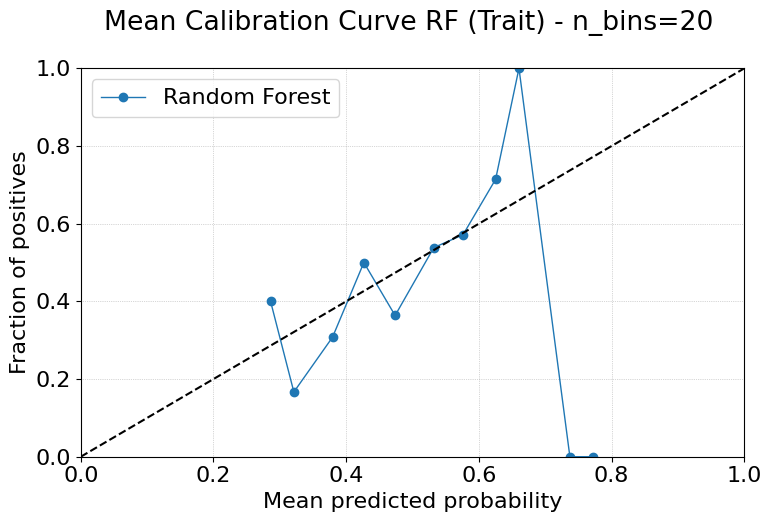

In [ ]:
rf_kfold_probability_stacked = np.hstack(rf_kfold_probability)
true_labels_stacked = np.hstack(true_labels)

rf_y, rf_x = calibration_curve(true_labels_stacked, rf_kfold_probability_stacked, n_bins=20)

# calibration curves
fig, ax = plt.subplots(figsize=(8,5.5))
ax.plot(rf_x, rf_y, marker='o', linewidth=1, label='Random Forest')
ax.set(
    title="Mean Calibration Curve RF (Trait) - n_bins=20 \n",
    xlabel="Mean predicted probability",
    ylabel="Fraction of positives",
    xlim=(0, 1),
    ylim=(0, 1),
)
ax.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()

import matplotlib.lines as mlines
# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], linestyle="--", color="black")
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

plt.legend()
plt.show()

## **SHAP Values**

In [ ]:
import textwrap

def wrap_labels(labels, width=55):
    return [textwrap.fill(label, width) for label in labels]

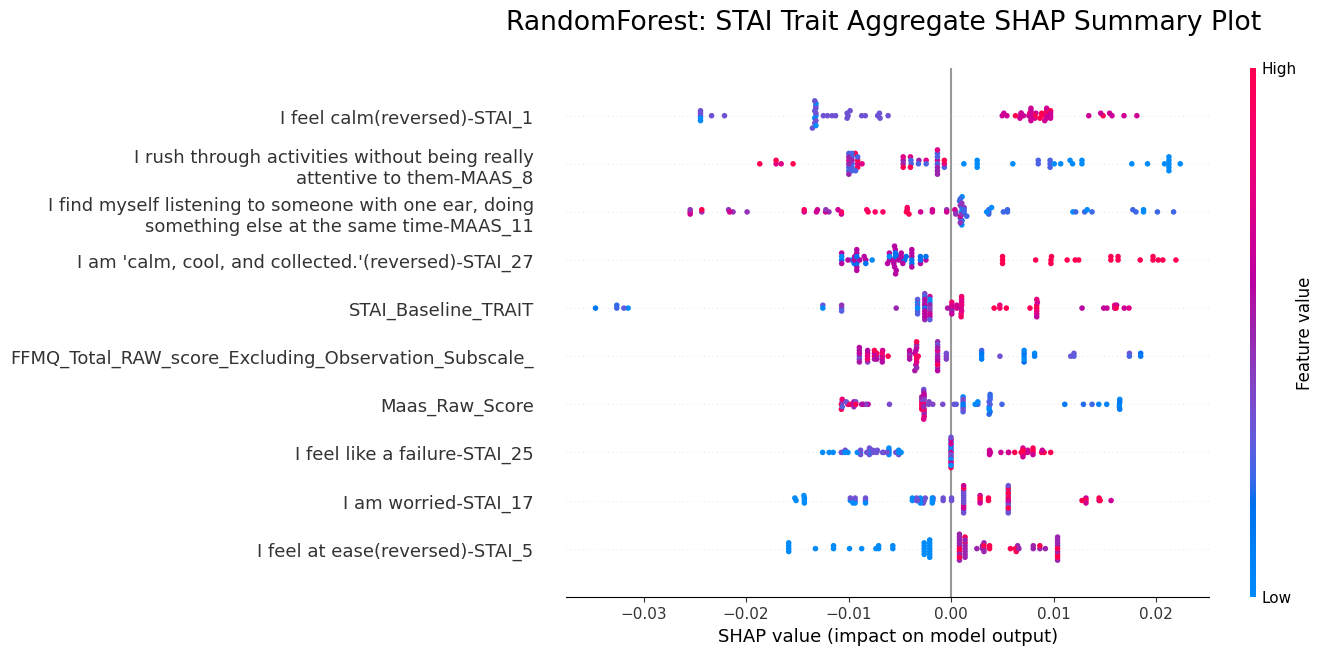

In [36]:
import textwrap
import re # Added
import json # Added

def wrap_labels(labels, width=55):
    return [textwrap.fill(label, width) for label in labels]

all_shap_values = []
all_X_test = []

for train_index, valid_index in cv_inner.split(X, y_trait):
    X_tr, X_val = X.iloc[train_index], X.iloc[valid_index]
    y_tr, y_val = y_trait[train_index], y_trait[valid_index]

    RandomF = RandomForestClassifier(random_state=1, class_weight='balanced', ccp_alpha=0.08818534583856608, max_depth=5, n_estimators=150)
    X_tr_scaled, X_val_scaled = Standardize_data(X_tr, X_val)

    RandomF.fit(X_tr_scaled, y_tr)

    #SHAP
    explainer = shap.TreeExplainer(RandomF)
    shap_values = explainer.shap_values(X_val_scaled)
    all_shap_values.append(shap_values)
    all_X_test.append(X_val_scaled)

# Combine SHAP values and X_test from all folds
combined_shap_values = np.vstack(all_shap_values)
original_X_test_df = pd.concat(all_X_test)

# Generate new column names based on the user's conditional mapping logic
final_column_names = []
for col in original_X_test_df.columns:
    mapped_name = result.get(col, col) # Get mapped name, or original if not found
    if re.search(r'\d', col): # Check if the original column name contains a digit
        final_column_names.append(f"{mapped_name}-{col}")
    else:
        final_column_names.append(mapped_name)

# Assign the new column names to the DataFrame used for plotting
combined_X_test = original_X_test_df.copy() # Create combined_X_test with new column names
combined_X_test.columns = final_column_names

# Wrap the newly created feature names for better display in the plot
wrapped_feature_names = wrap_labels(combined_X_test.columns)

shap.summary_plot(combined_shap_values[:,:,1], combined_X_test, feature_names=wrapped_feature_names, max_display=10, show=False)
plt.title("RandomForest: STAI Trait Aggregate SHAP Summary Plot \n")
plt.subplots_adjust(left=0.3)

# Save the plot as an SVG file
plt.gcf().set_size_inches(12,6.5)
plt.savefig('/content/drive/MyDrive/Mindful_Inter_Autism_Data/RF_TRAIT_SHAP_summary_plot.svg', format='svg', bbox_inches='tight')
plt.show()

# --------

## Evaluation with LOOCV

In [ ]:
aucs = []
feature_names = X.columns
counter = 0
models = list()
loo = LeaveOneOut()

predictions = []
true_labels = []
rf_kfold_probability = []

for train_index, valid_index in loo.split(X, y_trait):
    X_tr, X_val = X.iloc[train_index], X.iloc[valid_index]
    y_tr, y_val = y_trait[train_index], y_trait[valid_index]

    RandomF = RandomForestClassifier(random_state=1, class_weight='balanced', ccp_alpha=0.13175561560547216, n_estimators=50)

    X_tr_scaled, X_val_scaled = Standardize_data(X_tr, X_val)

    models.append(RandomF.fit(X_tr_scaled, y_tr))
    pred = RandomF.predict(X_val_scaled)
    pred_proba = RandomF.predict_proba(X_val_scaled)[:, 1]
    predictions.extend(pred)
    true_labels.extend(y_val)

    rf_kfold_probability.append(pred_proba)

    # feature importances
    importances = RandomF.feature_importances_
    feature_importance = pd.DataFrame(importances, index=feature_names,
                             columns=['importances'])
    feature_importance = feature_importance.sort_values(by='importances', ascending=False)

    std = np.std([tree.feature_importances_ for tree in RandomF.estimators_], axis=0)
    feature_odds = pd.DataFrame(importances, index=feature_names,
                             columns=['importances'])
    feature_odds = feature_odds.sort_values(by='importances', ascending=False)

    if counter == 0:
      fi_df = feature_importance.copy()
      counter += 1
    else:
      fi_df = pd.concat([fi_df,feature_importance], axis=1)

predictions = np.array(predictions)
true_labels = np.array(true_labels)
auc = roc_auc_score(true_labels, predictions)

In [ ]:
print(auc)

0.5964176829268293


In [ ]:
fi_df_copy = fi_df.copy()

fi_df_copy = fi_df_copy.groupby(fi_df_copy.columns, axis=1).sum()
save_to_drive = test.sort_values(by=['importances'], ascending=False).head(10)
save_to_drive

/tmp/ipython-input-3250197731.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  test = test.groupby(test.columns, axis=1).sum()


,importances
STAI_1,10.323400
MAAS_8,8.197239
STAI_Baseline_TRAIT,7.367444
STAI_11,6.390548
STAI_17,5.909219
FFMQ_Total_RAW_score_Excluding_Observation_Subscale_,4.702964
FFMQ_14,4.509219
FFMQ_9,4.376372
STAI_10,2.724521
STAI_20,2.665548


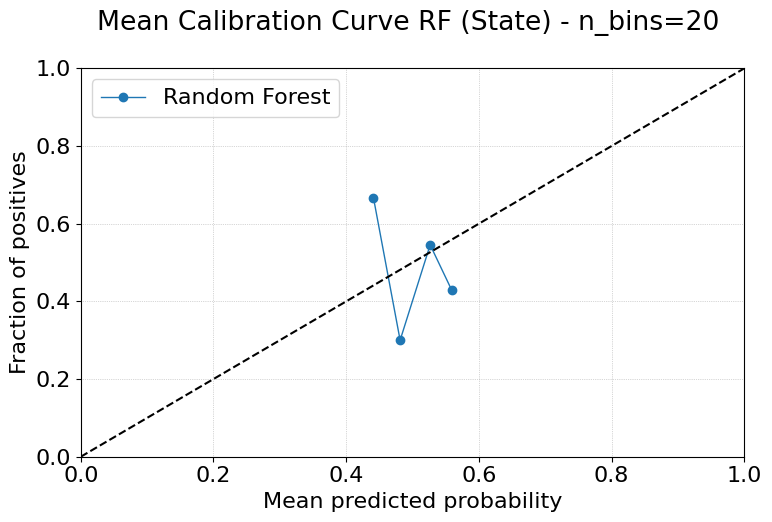

In [ ]:
rf_kfold_probability_stacked = np.hstack(rf_kfold_probability)
true_labels_stacked = np.hstack(true_labels)

rf_y, rf_x = calibration_curve(true_labels_stacked, rf_kfold_probability_stacked, n_bins=20)

# calibration curves
fig, ax = plt.subplots(figsize=(8,5.5))
ax.plot(rf_x, rf_y, marker='o', linewidth=1, label='Random Forest')
ax.set(
    title="Mean Calibration Curve RF (State) - n_bins=20 \n",
    xlabel="Mean predicted probability",
    ylabel="Fraction of positives",
    xlim=(0, 1),
    ylim=(0, 1),
)
ax.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()

import matplotlib.lines as mlines
# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], linestyle="--", color="black")
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

plt.legend()

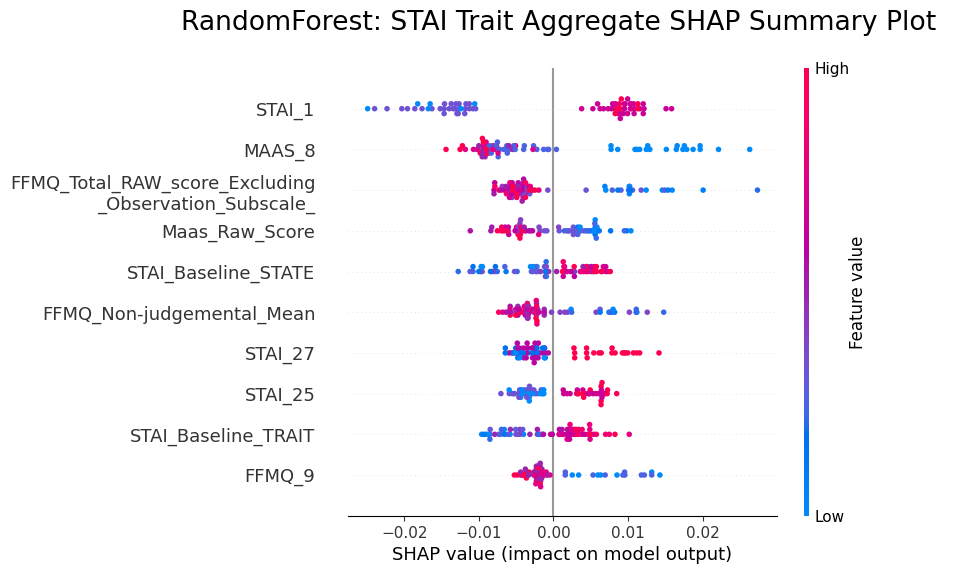

In [ ]:
all_shap_values = []
all_X_test = []

for train_index, valid_index in loo.split(X, y_trait):
    X_tr, X_val = X.iloc[train_index], X.iloc[valid_index]
    y_tr, y_val = y_trait[train_index], y_trait[valid_index]

    RandomF = RandomForestClassifier(random_state=1, class_weight='balanced', ccp_alpha=0.08818534583856608, max_depth=5, n_estimators=150)
    X_tr_scaled, X_val_scaled = Standardize_data(X_tr, X_val)

    RandomF.fit(X_tr_scaled, y_tr)

    #SHAP
    explainer = shap.TreeExplainer(RandomF, feature_names=wrapped_feature_names)
    shap_values = explainer.shap_values(X_val_scaled)
    all_shap_values.append(shap_values)
    all_X_test.append(X_val_scaled)

# Combine SHAP values and X_test from all folds
combined_shap_values = np.vstack(all_shap_values)
combined_X_test = pd.concat(all_X_test)

# Generate the aggregated summary plot
shap.summary_plot(combined_shap_values[:,:,1], combined_X_test, feature_names=wrapped_feature_names, max_display=10, show=False)
plt.title("RandomForest: STAI Trait Aggregate SHAP Summary Plot \n")
# fig.set_size_inches(10, 6) # Adjust as needed for your plot and feature name length
plt.subplots_adjust(left=0.3)
plt.show()